In [22]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import sklearn.metrics as m
import missingno as msno

In [23]:
url = 'https://raw.githubusercontent.com/digipodium/Datasets/main/regression/house_pricing.csv'
df = pd.read_csv(url)
df

,City,Type,Beds,Baths,SquareFeet,Price
0,SACRAMENTO,Residential,2,1,836,138159.85
1,SACRAMENTO,Residential,3,1,1167,167541.46
2,SACRAMENTO,Residential,2,1,796,119095.12
3,SACRAMENTO,Residential,2,1,852,130904.95
4,SACRAMENTO,Residential,2,1,797,120266.19
...,...,...,...,...,...,...
809,SACRAMENTO,Residential,4,3,2280,308248.47
810,SACRAMENTO,Residential,3,2,1477,212857.63
811,CITRUS HEIGHTS,Residential,3,2,1216,181746.98
812,ELK GROVE,Residential,4,2,1685,245385.59


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

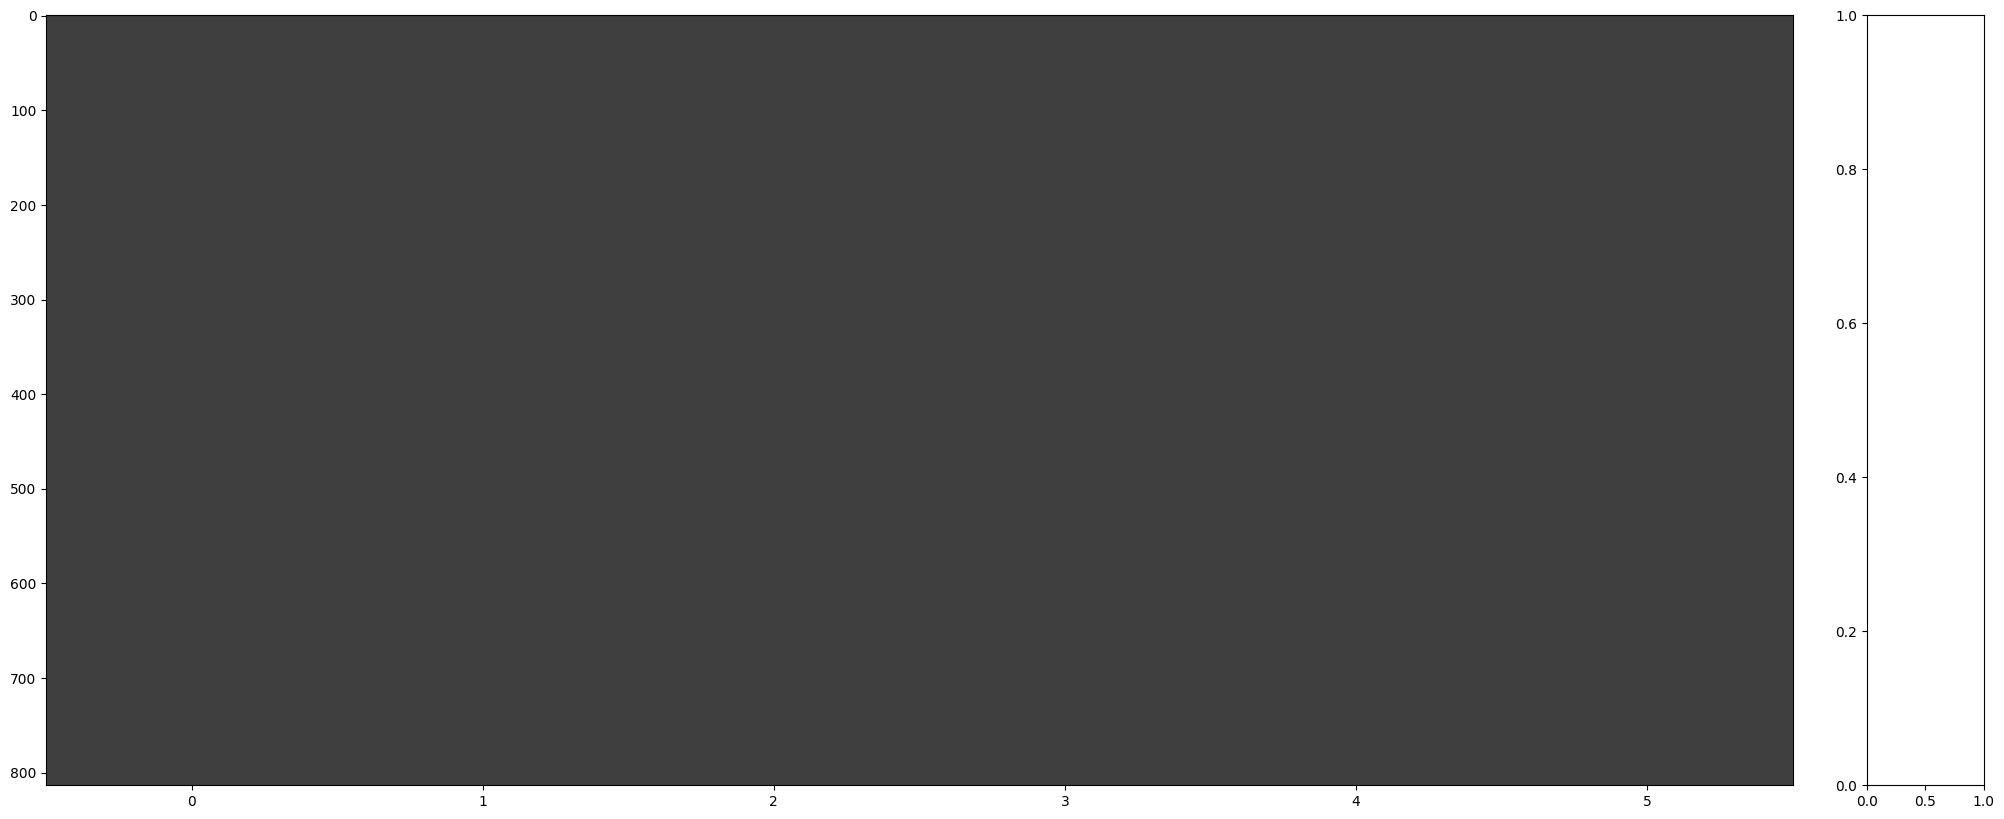

In [24]:
_ = msno.matrix(df)

In [ ]:
df.head()

,City,Type,Beds,Baths,SquareFeet,Price
0,SACRAMENTO,Residential,2,1,836,138159.85
1,SACRAMENTO,Residential,3,1,1167,167541.46
2,SACRAMENTO,Residential,2,1,796,119095.12
3,SACRAMENTO,Residential,2,1,852,130904.95
4,SACRAMENTO,Residential,2,1,797,120266.19


In [29]:
cat_cols = ['City','Type']
num_cols = ['Beds','Baths','SquareFeet']
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('hot_encode', OneHotEncoder(drop='first', handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, num_cols),
    ('categorical', cat_transformer, cat_cols),
])

model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_regression)),
    ('regressor', RandomForestRegressor(max_depth=50, n_estimators=100))
])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Beds', 'Baths',
                                                   'SquareFeet']),
                                                 ('categorical',
                                                  Pipeline(steps=[('hot_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['City', 'Type'])])),
                ('selector',
                 SelectKBest(score_func=<function f_regression at 0x000001A93DC0B910>)),
                ('regressor', RandomForestRegressor(max_depth=50))])

In [33]:
X = df.drop(columns='Price')
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'selector__k': [2,3,4,5],
    'regressor__max_depth': range(10,101,10),
    'regressor__n_estimators': range(10,101,10),
    'regressor__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"]
}

In [ ]:
results = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=3)
results.fit(X_train, y_train)

In [39]:
df = pd.DataFrame(results.cv_results_)

In [41]:
results.best_params_

{'regressor__criterion': 'friedman_mse',
 'regressor__max_depth': 10,
 'regressor__n_estimators': 10,
 'selector__k': 5}

In [42]:
ypred = results.predict(X_test)
print(f'{m.mean_absolute_error(y_test, ypred):.2f}')
print(f'{m.mean_squared_error(y_test, ypred):.2f}')
print(f'{m.r2_score(y_test, ypred):.2f}')

21870.09
1479062983.74
0.82


c:\Users\ZAID\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
